In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from tensorflow import keras



In [2]:
dataset_path = 'numpy_dataset'

In [3]:
dataset = []

for f in os.listdir(dataset_path) :
    with open(os.path.join(dataset_path, f), 'rb') as file:
        data = pickle.load(file)
        # print(f, data.shape)

        for i in range(data.shape[1]-30):
            dataset.append(data[:, i:i+30])
        
dataset = np.array(dataset)

In [4]:
dataset.shape

(11529, 5, 30, 2)

In [5]:
def generate_random_mask() :
    # generate random mask of shape (5, 30, 2) of ones
    # in this random (5, 3, 2) contineous block will be 0's
    mask = np.ones((5, 30, 2))
    start = np.random.randint(0, 30-3)
    mask[:, start:start+3] = 0
    return mask

def prepare_dataset(dataset):
    X = []
    Y = []
    for data in dataset:
        for i in range(10):
            tmp_data = data.copy()
            mask = generate_random_mask()
            tmp_data = tmp_data * mask
            x = np.concatenate([tmp_data, mask], axis=1)
            y = data
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [6]:
import random

random.shuffle(dataset)
X, Y = prepare_dataset(dataset)
train_split = 0.7
val_split = 0.15
test_split = 0.15
X_train = X[:int(X.shape[0]*train_split)]
Y_train = Y[:int(Y.shape[0]*train_split)]
X_val = X[int(X.shape[0]*train_split):int(X.shape[0]*(train_split+val_split))]
Y_val = Y[int(Y.shape[0]*train_split):int(Y.shape[0]*(train_split+val_split))]
X_test = X[int(X.shape[0]*(train_split+val_split)):]
Y_test = Y[int(Y.shape[0]*(train_split+val_split)):]
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(80703, 5, 60, 2) (80703, 5, 30, 2)
(17293, 5, 60, 2) (17293, 5, 30, 2)
(17294, 5, 60, 2) (17294, 5, 30, 2)


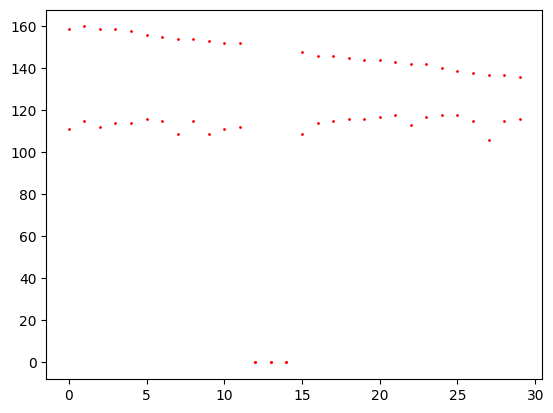

In [7]:
# plot dotted graph
plt.plot(X_train[0, 1, :30, :], 'ro', markersize=1)

In [8]:
def make_model() :
    # input shape (5, 60, 2)
    # output shape (5, 30, 2)
    inp = keras.layers.Input(shape=(5, 60, 2))
    x = keras.layers.Flatten()(inp) 
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dense(300, activation='relu')(x)
    x = keras.layers.Reshape((5, 30, 2))(x)
    out = x
    model = keras.Model(inp, out)
    return model
    

In [9]:
model = make_model()
model.load_weights('model_dnn.h5')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 60, 2)]        0         
                                                                 
 flatten (Flatten)           (None, 600)               0         
                                                                 
 dense (Dense)               (None, 256)               153856    
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 300)               153900    
                                                                 
 reshape (Reshape)           (None, 5, 30, 2)          0         
                                                                 
Total params: 439,340
Trainable params: 439,340
Non-trainable

In [11]:
model.compile(optimizer=keras.optimizers.Adam(0.0001), loss='mse', metrics=['mae'])

In [12]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=300, 
                    batch_size=32,
                    callbacks=[keras.callbacks.ModelCheckpoint('model_dnn.h5', save_best_only=True)])

Epoch 1/300
2522/2522 [==============================] - 14s 4ms/step - loss: 2.5715 - mae: 0.8540 - val_loss: 5.1567 - val_mae: 1.2582
Epoch 2/300
2522/2522 [==============================] - 10s 4ms/step - loss: 2.2713 - mae: 0.8420 - val_loss: 4.1001 - val_mae: 0.9149
Epoch 3/300
2522/2522 [==============================] - 9s 4ms/step - loss: 2.1173 - mae: 0.8291 - val_loss: 3.9282 - val_mae: 0.8582
Epoch 4/300
2522/2522 [==============================] - 9s 4ms/step - loss: 2.0295 - mae: 0.8218 - val_loss: 3.9625 - val_mae: 0.8373
Epoch 5/300
2522/2522 [==============================] - 9s 4ms/step - loss: 1.9698 - mae: 0.8151 - val_loss: 4.0135 - val_mae: 0.8748
Epoch 6/300
2522/2522 [==============================] - 9s 4ms/step - loss: 1.9276 - mae: 0.8100 - val_loss: 3.9525 - val_mae: 0.8518
Epoch 7/300
2522/2522 [==============================] - 10s 4ms/step - loss: 1.8919 - mae: 0.8039 - val_loss: 4.4231 - val_mae: 0.9008
Epoch 8/300
2522/2522 [=============================

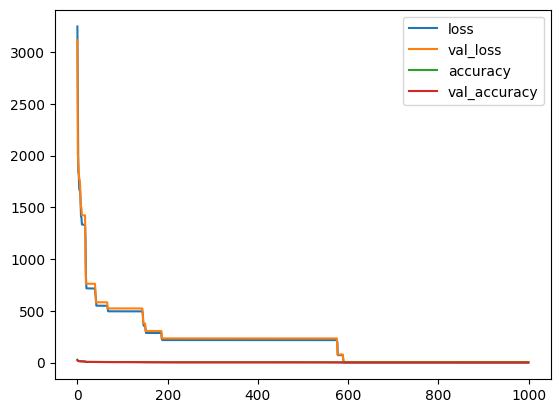

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']  
accuracy = history.history['mae']  
val_accuracy = history.history['val_mae']
plt.plot(loss)
plt.plot(val_loss)
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['loss', 'val_loss', 'accuracy', 'val_accuracy'])
plt.show()

1/1 [==============================] - 0s 34ms/step


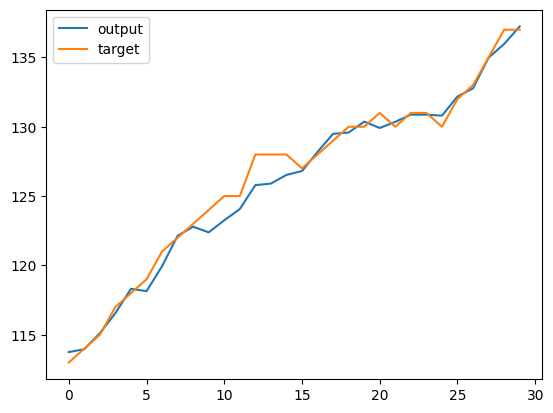

In [22]:
index = np.random.randint(0, X_test.shape[0])
keypoint_index = np.random.randint(0, 5)
y = model.predict(X_test[index:index+1])
# plt.plot(X_test[0, 1, :30], 'ro', markersize=1)
# plt.plot(y[0, 1], 'ro', markersize=1)
# plt.plot(Y_test[index, 1], 'bo', markersize=1)
# plt.plot(X_test[index, keypoint_index, :30, 0], 'o', markersize=1)
plt.plot(y[0, keypoint_index, :, 0], '-', markersize=1)
plt.plot(Y_test[index, keypoint_index, :, 0], '-', markersize=1)
plt.legend(['output', 'target'])

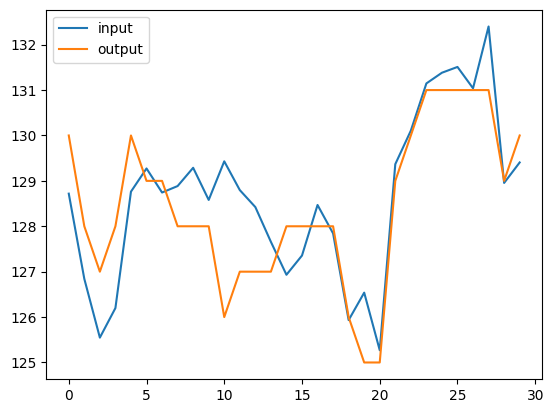

In [23]:
# plt.plot(X_test[index, keypoint_index, :30, 1], 'o', markersize=1)
plt.plot(y[0, keypoint_index, :, 1], '-', markersize=1)
plt.plot(Y_test[index, keypoint_index, :, 1], '-', markersize=1)
plt.legend(['input', 'output', 'target'])

In [16]:
keypoint_index

4

In [13]:
y_out = model.predict(X_test)

541/541 [==============================] - 1s 2ms/step


In [14]:

# mse loss on test data
mse_loss = np.mean((Y_test - y_out)**2)

# mape loss on test data
mape_score = np.mean(np.abs((Y_test - y_out)/(Y_test + 1e-1)))

print("MSE Loss on Test Data : ", mse_loss)
print("MAPE Score on Test Data : ", mape_score)

MSE Loss on Test Data :  7.4277027780903575
MAPE Score on Test Data :  0.02010287844916567


In [19]:
keypoint_names = [
    'nose',  # 0
    'left_eye',  # 1
    'right_eye', # 2
    'left_ear', # 3
    'right_ear', # 4
    'left_shoulder', # 5 
    'right_shoulder', # 6
    'left_elbow', # 7
    'right_elbow', # 8
    'left_wrist', # 9
    'right_wrist', # 10
    'left_hip', # 11
    'right_hip', # 12
    'left_knee', # 13
    'right_knee', # 14
    'left_ankle', # 15
    'right_ankle' # 16
    ]

keypoints_to_detect = [
    5, # left shoulder
    7, # left elbow
    9, # left wrist
    13, # left knee
    15, # left ankle
]

In [20]:
keypoint_names[keypoints_to_detect[keypoint_index]]

'left_ankle'

In [21]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [7]:
model = tf.keras.models.load_model('model_dnn.h5')

1/1 [==============================] - 0s 22ms/step


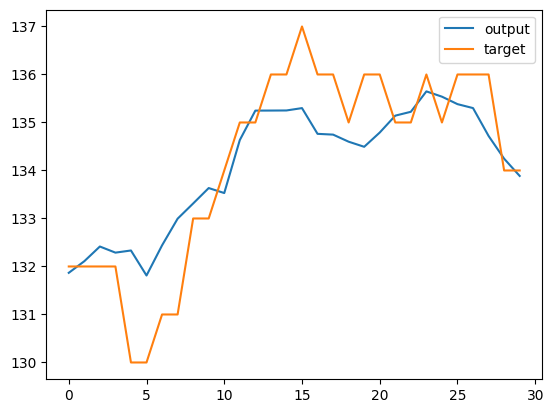

In [10]:
index = np.random.randint(0, X_test.shape[0])
keypoint_index = np.random.randint(0, 5)
y = model.predict(X_test[index:index+1])
# plt.plot(X_test[0, 1, :30], 'ro', markersize=1)
# plt.plot(y[0, 1], 'ro', markersize=1)
# plt.plot(Y_test[index, 1], 'bo', markersize=1)
# plt.plot(X_test[index, keypoint_index, :30, 0], 'o', markersize=1)
plt.plot(y[0, keypoint_index, :, 0], '-', markersize=1)
plt.plot(Y_test[index, keypoint_index, :, 0], '-', markersize=1)
plt.legend(['output', 'target'])

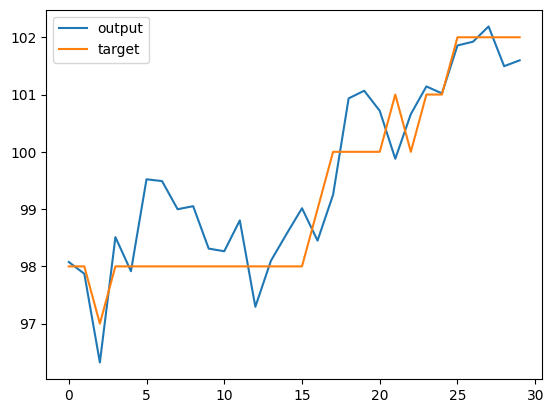

In [11]:
plt.plot(y[0, keypoint_index, :, 1], '-', markersize=1)
plt.plot(Y_test[index, keypoint_index, :, 1], '-', markersize=1)
plt.legend(['output', 'target'])